# Stitching two images

For this problem, we have two images -- `tour_eiffel_left.jpg` and `tour_eiffel_right.jpg`, which were extracted from a bigger image. <br>
We want to *stitch* these images together so that we can form a bigger image out of two smaller images. 

### Import the packages

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.sparse import lil_matrix

%matplotlib inline

### Loading the two images

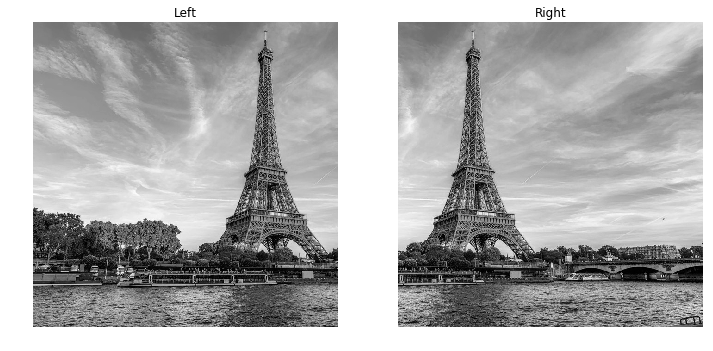

In [2]:
left_img   = cv2.imread('images/tour_eiffel_left.jpg')
left_img   = cv2.cvtColor(left_img, cv2.COLOR_RGB2GRAY)

right_img  = cv2.imread('images/tour_eiffel_right.jpg')
right_img  = cv2.cvtColor(right_img, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(left_img, cmap='gray')
plt.axis('off')
plt.title('Left')

plt.subplot(1, 2, 2)
plt.imshow(right_img, cmap='gray')
plt.axis('off')
plt.title('Right')

plt.show()

### Steps of the problem

We will try to solve this problem using the Harris corner detector and the RANdom SAmple Consensus (RANSAC) algorithm. 

The steps are the following :
* Find corner points in both images using the Harris corner detector. 
* Choose a random pair of points&mdash;one from the left image, and the other from the right. 
* We will assume that this pair represents the same location in the scene in both images. This gives a translation vector, so the we can superimpose this point in the right image onto the left image.
* The translation gives us an overlapping region, which can be given a similarity score. 
* If we keep choosing this pair of points randomly, we can keep improving our similarity score until we have found the best match. 

Below are implemented these different steps

### Implementation of the Harris corner detector

In [3]:
def gradient_xy(image):
    """We compute the derivatives along x and y axis"""
    first_sobel_operator = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    second_sobel_operator = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    g_x = convolve2d(image, first_sobel_operator, mode = "same", boundary = "symm")
    g_y = convolve2d(image, second_sobel_operator, mode = "same", boundary = "symm")
    return g_x, g_y

def compute_h(gx, gy):
    """We define h as a tensor of shape (2, 2, shape of gx(same as gy))"""
    h = np.zeros((2, 2, *gx.shape))
    h[0, 0] = gx ** 2
    h[1, 1] = gy ** 2
    h[0, 1] = gx * gy
    h[1, 0] = h[1, 0]
    return h

def tensor_score(h, k):
    """We coded the formulation of the Harris score found in the litterature"""
    det = h[0, 0] * h[1, 1] - h[1, 0] * h[0, 1]
    trace = h[0, 0] + h[1, 1]
    r = det - k * trace ** 2
    threshold = r.max()/100
    
    return np.where(r > threshold, 1, 0)

def non_maximum_suppression(image):
    """We want to keep only the local maximums in the created image"""
    
    corners = lil_matrix(image.shape)
    thresh = image.max()/50
    for (x,y) in zip(image.nonzero()[0],image.nonzero()[1]):
        x1 = max(x-2,0)
        y1 = max(y-2,0)
        
        if image[x,y] >= np.max(image[x1:x+3,y1:y+3]) and image[x,y]>thresh:
            corners[x,y] = 1

    return corners

def harris_corner_detector(img, k=0.04):
    """Let's compute the harris corner detection using the previous functions"""
    gx, gy = gradient_xy(img)
    h = compute_h(gx, gy)
    harris_image = tensor_score(h, k)
    return non_maximum_suppression(harris_image)

### Create a random pair, a translation vector and compute the similarity score associated

In [4]:
def find_random_pair(corners_left, corners_right):
    "Let's select points among the points detected"
    left_corners_number = corners_left.count_nonzero()
    right_corners_number = corners_right.count_nonzero()
    
    rand_left = np.random.randint(0,left_corners_number)
    rand_right = np.random.randint(0,right_corners_number)
    
    return ((corners_left.nonzero()[0][rand_left],corners_left.nonzero()[1][rand_left]),
            (corners_right.nonzero()[0][rand_right],corners_right.nonzero()[1][rand_right]))
    
def find_translation_vector(c_left, c_right):
    """Let's compute the translation vector"""
    return (c_right[0]-c_left[0],c_right[1]-c_left[1])

def compute_error(left, right, x_trans, y_trans):
    """The goal fo this function is to compute the error"""
    right = right.toarray()
    left = left.toarray()
    
    left_overlap_x_min = max(0, -x_trans)
    left_overlap_x_max = left.shape[0] - max(0, x_trans)
    
    right_overlap_x_min = max(0, x_trans)
    right_overlap_x_max = right.shape[0] - max(0, -x_trans)
    
    left_overlap_y_min = max(0, -y_trans)
    left_overlap_y_max = left.shape[1] - max(0, y_trans)
    
    right_overlap_y_min = max(0, y_trans)
    right_overlap_y_max = right.shape[1] - max(0, -y_trans)
    
    left_overlap = left[left_overlap_x_min:left_overlap_x_max-1,
                        left_overlap_y_min:left_overlap_y_max-1]
    right_overlap = right[right_overlap_x_min:right_overlap_x_max-1,
                          right_overlap_y_min:right_overlap_y_max-1]
        
    nb_common_points = 0
    for i in range(left_overlap.shape[0]):
        for j in range(left_overlap.shape[1]):
            nb_common_points += left_overlap[i,j]*right_overlap[i,j]
                
    if nb_common_points == 0:
        return np.inf
    return 1/nb_common_points

### Stiching the two images using RANSAC algorithm

In [5]:
def stitch_images(left, right, max_tries=1000):
    """Let's stitch the images"""
    # Find corner points
    
    corners_left  = harris_corner_detector(left)
    corners_right = harris_corner_detector(right)    
    
    best_error = 255*left.shape[0]*left.shape[1]
    best_trans = None
    
    for n_try in range(max_tries):
        # Choose two points randomly
        c_left, c_right  = find_random_pair(corners_left, corners_right)

        # Get translation vector
        x_trans, y_trans = find_translation_vector(c_left, c_right)

        # Compute resulting error. 
        this_error       = compute_error(corners_left, corners_right, x_trans, y_trans)

        # Keep the best translation vector
        if this_error < best_error and x_trans*y_trans > 0:
            best_error   = this_error
            best_trans   = x_trans, y_trans
            
    stiched_image_shape = left.shape[0]+abs(best_trans[0]),left.shape[1]+abs(best_trans[1])
    stitched_image = np.zeros(stiched_image_shape)
    x_trans, y_trans =  best_trans

    try:
        stitched_image[:right.shape[0],:right.shape[1]] = right
        stitched_image[x_trans:,y_trans:] = left
        return stitched_image
    except : 
        print("Exception occured...")
        return stitch_images(left,right, max_tries=max_tries) #If we don't have x_trans and y_trans positives we just rerun the process.
    

### Try our stiching algorithm on our images

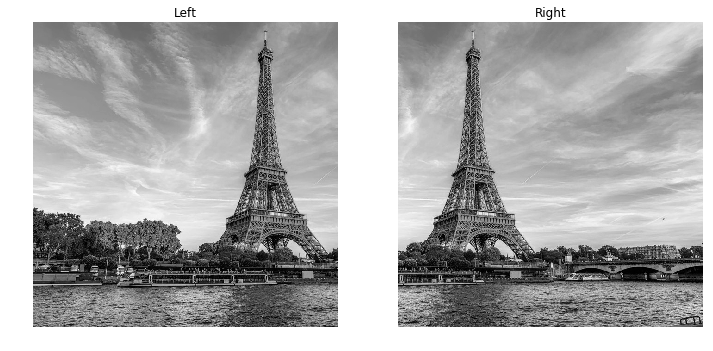

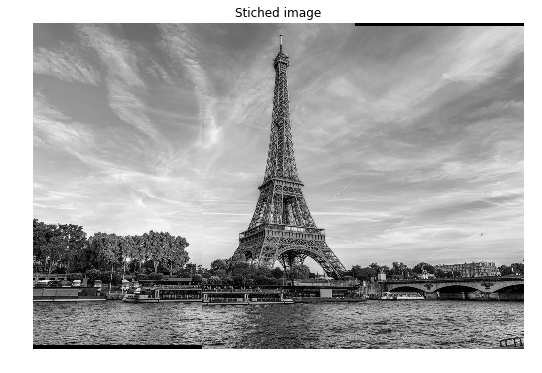

True

In [6]:
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(left_img, cmap='gray')
plt.axis('off')
plt.title('Left')

plt.subplot(1, 2, 2)
plt.imshow(right_img, cmap='gray')
plt.axis('off')
plt.title('Right')
plt.show()

plt.figure(figsize=(12,6))
stiched = stitch_images(right_img, left_img, max_tries=2000)
plt.imshow(stiched,cmap="gray")
plt.axis('off')
plt.title('Stiched image')
plt.show()

cv2.imwrite('./stiched_images/tour_eiffel_stiched.jpg', stiched)

### Try on other examples

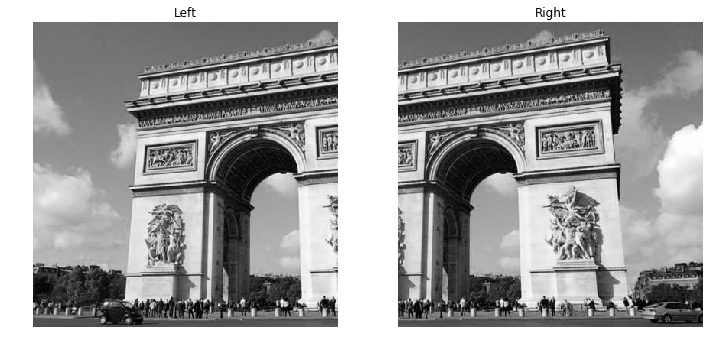

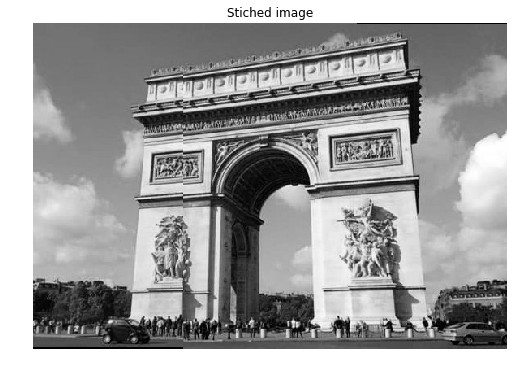

True

In [7]:
left_img   = cv2.imread('images/arc_de_triomphe_left.jpg')
left_img   = cv2.cvtColor(left_img, cv2.COLOR_RGB2GRAY)

right_img  = cv2.imread('images/arc_de_triomphe_right.jpg')
right_img  = cv2.cvtColor(right_img, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(left_img, cmap='gray')
plt.axis('off')
plt.title('Left')

plt.subplot(1, 2, 2)
plt.imshow(right_img, cmap='gray')
plt.axis('off')
plt.title('Right')
plt.show()

plt.figure(figsize=(12,6))
stiched = stitch_images(right_img, left_img, max_tries=2000)
plt.imshow(stiched,cmap="gray")
plt.axis('off')
plt.title('Stiched image')
plt.show()

cv2.imwrite('./stiched_images/arc_de_triomphe_stiched.jpg', stiched)

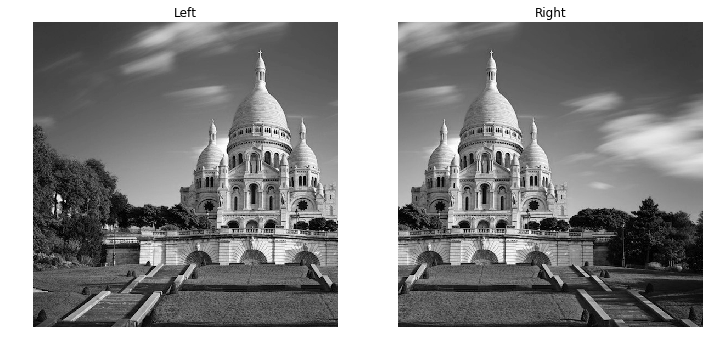

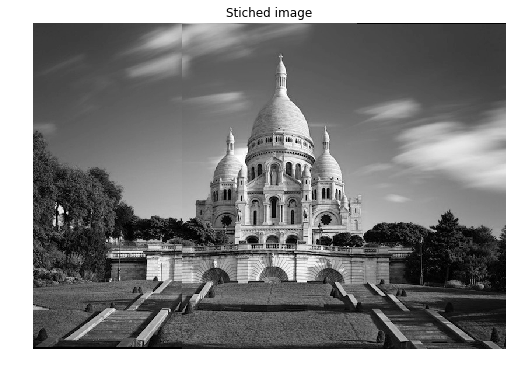

True

In [8]:
left_img   = cv2.imread('images/sacre_coeur_left.jpg')
left_img   = cv2.cvtColor(left_img, cv2.COLOR_RGB2GRAY)

right_img  = cv2.imread('images/sacre_coeur_right.jpg')
right_img  = cv2.cvtColor(right_img, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(left_img, cmap='gray')
plt.axis('off')
plt.title('Left')

plt.subplot(1, 2, 2)
plt.imshow(right_img, cmap='gray')
plt.axis('off')
plt.title('Right')
plt.show()

plt.figure(figsize=(12,6))
stiched = stitch_images(right_img, left_img, max_tries=2000)
plt.imshow(stiched,cmap="gray")
plt.axis('off')
plt.title('Stiched image')
plt.show()

cv2.imwrite('./stiched_images/sacre_coeur_stiched.jpg', stiched)